In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import random
from datetime import datetime

import torch
import torch.utils
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda
import torch.nn as nn
from torchvision import transforms
from torchmetrics.classification import BinaryJaccardIndex

from PIL import Image

# Model

In [2]:
class ResNet(nn.Module):

    def __init__(self, epsilon, momentum):
        super(ResNet, self).__init__()

        # Encoder (Takes 896x896 RGB image)
        self.start = nn.Sequential(nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
                                   nn.BatchNorm2d(32, epsilon, momentum),
                                   nn.ReLU()
                                   )

        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.encoder_1 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64, epsilon, momentum)
                                       )

        self.encoder_1_bypass = nn.Conv2d(32, 64, kernel_size=1)

        self.encoder_2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128, epsilon, momentum)
                                       )

        self.encoder_2_bypass = nn.Conv2d(64, 128, kernel_size=1)

        self.encoder_3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256, epsilon, momentum)
                                       )

        self.encoder_3_bypass = nn.Conv2d(128, 256, kernel_size=1)

        self.encoder_4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512, epsilon, momentum)
                                       )

        self.encoder_4_bypass = nn.Conv2d(256, 512, kernel_size=1)

        # Decoder, returns mask

        self.upscale = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.decoder_1 = nn.Sequential(nn.Conv2d(768, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256, epsilon, momentum)
                                       )

        self.decoder_1_bypass = nn.Conv2d(768, 256, kernel_size=1)

        self.decoder_2 = nn.Sequential(nn.Conv2d(384, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128, epsilon, momentum)
                                       )

        self.decoder_2_bypass = nn.Conv2d(384, 128, kernel_size=1)

        self.decoder_3 = nn.Sequential(nn.Conv2d(192, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64, epsilon, momentum)
                                       )

        self.decoder_3_bypass = nn.Conv2d(192, 64, kernel_size=1)

        self.decoder_4 = nn.Sequential(nn.Conv2d(96, 32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32, epsilon, momentum),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32, epsilon, momentum)
                                       )

        self.decoder_4_bypass = nn.Conv2d(96, 32, kernel_size=1)

        self.decoder_last = nn.Conv2d(32, 1, kernel_size=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        # Input: Image 896x896x3 (896x896 pixels RGB)
        # ResNet encoder
        out1 = self.start(data)
        out_pool1 = self.max_pool(out1)

        # 224x224x64
        out2 = self.encoder_1(out_pool1)
        out2a = self.encoder_1_bypass(out_pool1)
        out2 = nn.ReLU()(out2 + out2a)
        out_pool2 = self.max_pool(out2)

        # 112x112x128
        out3 = self.encoder_2(out_pool2)
        out3a = self.encoder_2_bypass(out_pool2)
        out3 = nn.ReLU()(out3 + out3a)
        out_pool3 = self.max_pool(out3)

        # 56x56x256
        out4 = self.encoder_3(out_pool3)
        out4a = self.encoder_3_bypass(out_pool3)
        out4 = nn.ReLU()(out4 + out4a)
        out_pool4 = self.max_pool(out4)

        # 28x28x512
        out5 = self.encoder_4(out_pool4)
        out5a = self.encoder_4_bypass(out_pool4)
        out5 = nn.ReLU()(out5 + out5a)

        # ResNet decoder
        out6 = self.upscale(out5)

        # 56x56x512
        out6 = torch.cat((out6, out4), dim=1)
        out6a = self.decoder_1_bypass(out6)
        out6 = self.decoder_1(out6)
        out6 = nn.ReLU()(out6 + out6a)

        #56x56x256
        out7 = self.upscale(out6)

        # 112x112x256
        out7 = torch.cat((out7, out3), dim=1)
        out7a = self.decoder_2_bypass(out7)
        out7 = self.decoder_2(out7)
        out7 = nn.ReLU()(out7 + out7a)

        #112x112x128
        out8 = self.upscale(out7)

        # 224x224x128
        out8 = torch.cat((out8, out2), dim=1)
        out8a = self.decoder_3_bypass(out8)
        out8 = self.decoder_3(out8)
        out8 = nn.ReLU()(out8 + out8a)

        # 224x224x64
        out9 = self.upscale(out8)

        # 448x448x64
        out9 = torch.cat((out9, out1), dim=1)
        out9a = self.decoder_4_bypass(out9)
        out9 = self.decoder_4(out9)
        out9 = nn.ReLU()(out9 + out9a)

        # 448x448x32
        out10 = self.upscale(out9)

        # 896x896x32
        out10 = self.decoder_last(out10)
        out10 = self.sigmoid(out10)

        #896x896x1
        return out10


In [3]:
# HYPER-PARAMETERS

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.empty_cache()
image_size = (896, 896)
batch_size = 3

# Data Loader

In [4]:
class ImageDataset(Dataset):

    def __init__(self, path, image_size):
        self.path = path
        self.annotations = {}
        with open(f"{self.path}/annotations.txt") as file:
            for line in file.readlines():
                a, b = line.split(":")
                self.annotations[int(a)] = b.strip()
        self.image_size = image_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name = self.annotations.get(idx)
        image = Image.open(f"{self.path}/{image_name}.JPG")
        image = image.resize(self.image_size)
        mask = Image.open(f"{self.path}/{image_name}_mask2.png")
        mask = transforms.Grayscale(1)(mask)
        mask = mask.resize(self.image_size)

        angle = random.randrange(-8, 8)
        crop_num = random.randint(0, 2)
        crop_factors = [(896, 896), (650, 650), (448, 448)]
        flip_chance = random.randint(0, 5)
        persp_chance = random.randint(0, 5)
        # print(self.image_size)

        image = transforms.CenterCrop(crop_factors[crop_num])(image).resize(self.image_size)
        mask = transforms.CenterCrop(crop_factors[crop_num])(mask).resize(self.image_size)

        # if persp_chance > 3:
        #   start_p, end_p = transforms.RandomPerspective.get_params(image_size[0], image_size[1], 0.05)
        #   image = transforms.functional.perspective(image, start_p, end_p)
        #   mask = transforms.functional.perspective(mask, start_p, end_p)

        image = image.rotate(angle)
        mask = mask.rotate(angle)

        if flip_chance > 2:
            image = transforms.RandomHorizontalFlip(1)(image)
            mask = transforms.RandomHorizontalFlip(1)(mask)
        
        image = transforms.ToTensor()(image)

        mask = transforms.ToTensor()(mask)
        mask[mask > 0] = 1

        return {'image' : image, 'mask' : mask}


In [5]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [6]:
dataset = ImageDataset("../images", image_size)

train_size = round(len(dataset) * 0.75)
train, test = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train, batch_size, shuffle=True)
test_loader = DataLoader(train, batch_size)

# Training

In [7]:
model = ResNet(0.00001, 10e-5)
model.to(device)

# HYPER-PARAMETERS
epochs = 25
learning_rate = 0.00018
lr_multiplier = 0

In [8]:
def training_step(model, batch, device, criterion):
    images = batch['image'].to(device)
    masks = batch['mask'].to(device)
    out = model(images)
    loss = criterion(out, masks)
    return loss

def validation_step(model, batch, device, criterion):
    images = batch['image'].to(device)
    masks = batch['mask'].to(device)
    out = model(images)
    loss = criterion(out, masks)
    avg = out.mean().item()
    accuracy = BinaryJaccardIndex(threshold=avg).to(device)(out, masks)
    return {'loss' : loss, 'accuracy' : accuracy}

def epoch_end(epoch, result):
     print("Epoch {}: Loss: {:4.4f}, Accuracy: {:3.3f} %".format(epoch, result['loss'], result['accuracy'] * 100))

def evaluate(model, test_loader, device, criterion):

    out = [validation_step(model, batch, device, criterion) for batch in test_loader]
    loss, accuracy = [], []

    for result in out:
        loss.append(result['loss'])
        accuracy.append(result['accuracy'])

    return {'loss': torch.stack(loss).mean().item(), 'accuracy': torch.stack(accuracy).mean().item()}

In [9]:
def fit(epochs, model, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    criterion=nn.BCELoss()
    results = []

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.4, patience=4, verbose=True)

    for epoch in range(epochs):

        model.train()
        batch = next(iter(train_loader))
        loss = training_step(model, batch, device, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Loss: {:.4f}'.format(loss.item()))
        torch.cuda.empty_cache()

        model.eval()
        with torch.no_grad():
            result = evaluate(model, test_loader, device, criterion)
            epoch_end(epoch, result)
            results.append(result)
            torch.cuda.empty_cache()
            scheduler.step(result['accuracy'])


    return results

Loss: 0.6990
Epoch 0: Loss: 0.6908, Accuracy: 59.601 %
Loss: 0.5588
Epoch 1: Loss: 0.6907, Accuracy: 61.219 %
Loss: 0.5330
Epoch 2: Loss: 0.6874, Accuracy: 63.650 %
Loss: 0.4417
Epoch 3: Loss: 0.6889, Accuracy: 62.780 %
Loss: 0.5743
Epoch 4: Loss: 0.6878, Accuracy: 63.424 %
Loss: 0.4189
Epoch 5: Loss: 0.6874, Accuracy: 64.442 %
Loss: 0.4046
Epoch 6: Loss: 0.6909, Accuracy: 61.046 %
Loss: 0.4121
Epoch 7: Loss: 0.6888, Accuracy: 62.582 %
Loss: 0.3357
Epoch 8: Loss: 0.6876, Accuracy: 64.613 %
Loss: 0.3743
Epoch 9: Loss: 0.6866, Accuracy: 64.350 %
Loss: 0.3333
Epoch 10: Loss: 0.6887, Accuracy: 63.736 %
Loss: 0.3255
Epoch 11: Loss: 0.6918, Accuracy: 62.497 %
Loss: 0.3470
Epoch 12: Loss: 0.6828, Accuracy: 67.778 %
Loss: 0.2856
Epoch 13: Loss: 0.6868, Accuracy: 65.125 %
Loss: 0.2998
Epoch 14: Loss: 0.6876, Accuracy: 63.022 %
Loss: 0.2937
Epoch 15: Loss: 0.6822, Accuracy: 67.405 %
Loss: 0.2546
Epoch 16: Loss: 0.6876, Accuracy: 64.518 %
Loss: 0.2478
Epoch 17: Loss: 0.6892, Accuracy: 63.152 %
Ep

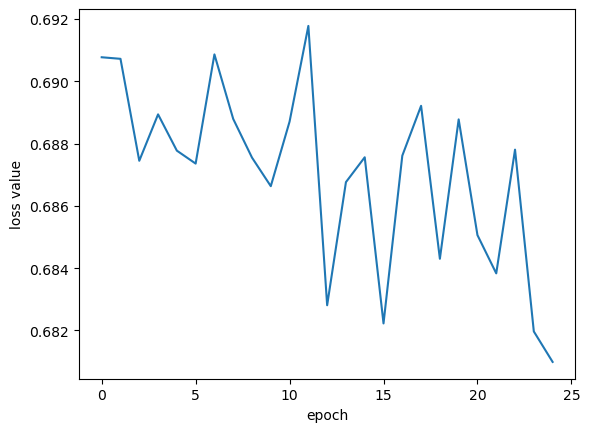

In [52]:
stats = fit(epochs, model, train_loader, test_loader)

loss = [x['loss'] for x in stats]
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

# Prediction

In [43]:
def predict(image):
    model.eval()

    image = image.resize(image_size)
    image = transforms.ToTensor()(image)

    image = image.unsqueeze(0)

    prediction = model(image.to(device)).flatten(start_dim=0, end_dim=2)
    prediction = prediction.cpu().detach().numpy()
    avg = prediction.mean()
    prediction[prediction > avg] = 1
    prediction[prediction <= avg] = 0
    print(prediction.shape)
    prediction = cv.morphologyEx(prediction, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(9,9)))

    torch.cuda.empty_cache()
    return Image.fromarray(prediction*255)

(896, 896)


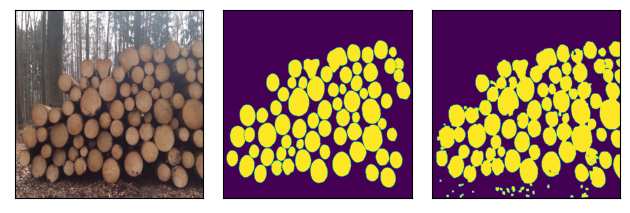

In [120]:
image = Image.open("../images/IMG_0133.JPG").resize(image_size)
mask = Image.open("../images/IMG_0133_mask2.png").resize(image_size)

result = predict(image)

plot([image, mask, result])
plt.show()

In [ ]:
mask = Image.open("../images/IMG_0133_mask2.png")

mask = transforms.ToTensor()(mask)
print(mask.shape)
mask[mask > 0] = 1.0

plot(mask)
plt.show()

In [164]:
time = datetime.now()
print(time)

torch.save(model.state_dict(), "model_" + time.strftime("%d_%m_%y_%H_%M_%S"))

2023-04-19 08:32:54.013957


# Post-training

In [11]:
model.load_state_dict(torch.load("model_75_googlecolab"))

<All keys matched successfully>

(896, 896)
<PIL.Image.Image image mode=L size=896x896 at 0x2E7E2710670>


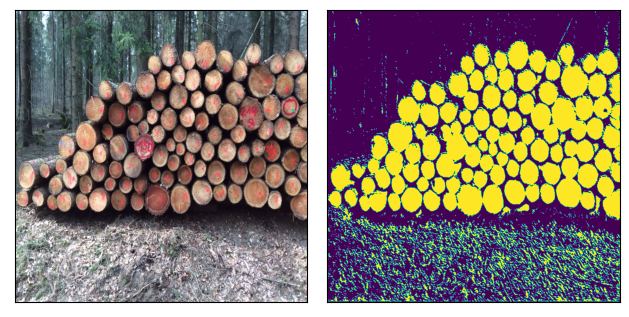

In [44]:
image = Image.open("../images/test.JPG").resize(image_size)
#image = transforms.CenterCrop((380, 380))(image).resize(image_size)

result = predict(image)

result = result.convert("L")
result.save("../mask.png", "PNG")
print(result)

plot([image, result])
plt.show()

In [19]:
def draw_circles(src, circles):
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            # circle center
            cv.circle(src, center, 1, (0, 100, 100), 3)
            # circle outline
            radius = i[2]
            cv.circle(src, center, radius, (255, 0, 0), 3)

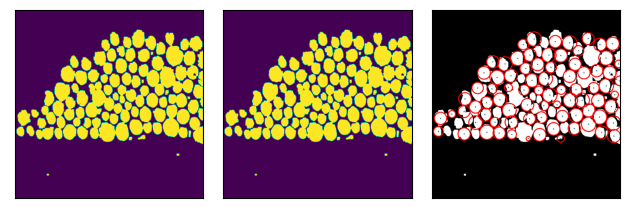

In [131]:
cv_result = cv.normalize(src=np.array(result), dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
cv_result = cv.medianBlur(cv_result, 3)
rows = cv_result.shape[0]
circles = cv.HoughCircles(cv_result, cv.HOUGH_GRADIENT, 1, rows / 16,
                               param1=50, param2=7,
                               minRadius=7, maxRadius=35)

# print(circles)
cv_result_C = cv.cvtColor(cv_result, cv.COLOR_GRAY2BGR)
draw_circles(cv_result_C, circles)

plot([result, cv_result, cv_result_C])
plt.show()

In [132]:
cv.imwrite("mask_with_circles.png", cv_result_C)

True